In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt

os.chdir("..")
from assistive_arm.utils.data_preprocessing import prepare_mocap_data, prepare_opencap_data, prepare_mocap_force_df, read_headers, export_filtered_force, sync_mocap_with_opencap, transform_force_coordinates
from assistive_arm.utils.file_modification import modify_force_xml

## Read data

In [13]:
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject testing/Subject data/subject_1")
project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")

# Set directories
trial = subject_data / "trial_2"

plate_20 = trial / "mocap_f_20.tsv"
plate_21 = trial / "mocap_f_21.tsv"

In [14]:

modify_force_xml('./moco/forces/grf_sit_stand.xml', str(trial / "grf_filtered.mot"))

In [15]:
# Read force data
mocap_forces = {}

for side, plate in zip(["r", "l"], [plate_20, plate_21]):
    # It must always be in this order
    col_names = [
        f"ground_force_{side}_vx",
        f"ground_force_{side}_vy",
        f"ground_force_{side}_vz",
        f"ground_force_{side}_px",
        f"ground_force_{side}_py",
        f"ground_force_{side}_pz",
        f"ground_torque_{side}_x",
        f"ground_torque_{side}_y",
        f"ground_torque_{side}_z",
        "nan"]
    mocap_forces[side] = {"headers": None, "data": None}
    mocap_forces[side]["headers"] = read_headers(plate, 25)[9:21]
    mocap_forces[side]["data"] = pd.read_csv(
        plate, 
        delimiter="\t", 
        skiprows=26, 
        names=[f"ground_force_{side}_vx", f"ground_force_{side}_vy", f"ground_force_{side}_vz", f"ground_torque_{side}_x", f"ground_torque_{side}_y", f"ground_torque_{side}_z", f"ground_force_{side}_px", f"ground_force_{side}_py", f"ground_force_{side}_pz", "nan"])
    mocap_forces[side]["data"] = mocap_forces[side]["data"].reindex(columns=col_names)

# Read mocap marker data
mocap_marker_names = read_headers(trial / "mocap_markers.tsv", 10)[-1][-2:] # Read row 10 and get marker names
mocap_markers = pd.read_csv(trial / "mocap_markers.tsv", delimiter="\t", skiprows=11)

# Read opencap marker data
headers = read_headers(trial / "opencap_tracker.trc", 3)  
opencap_markers = pd.read_csv(trial / "opencap_tracker.trc", delimiter="\t", skiprows=3).tail(-1)

## Process data

In [16]:
# Prepare mocap data
mocap_markers = prepare_mocap_data(df=mocap_markers, marker_names=mocap_marker_names)
opencap_markers = prepare_opencap_data(opencap_markers)
mocap_forces_in_world_frame = prepare_mocap_force_df(force_plate_data=mocap_forces, forces_in_world=True)

In [18]:
mocap_markers, mocap_forces_in_world_frame, opencap_markers = sync_mocap_with_opencap(marker_data=mocap_markers, force_data=mocap_forces_in_world_frame, opencap_data=opencap_markers)
opencap_origin = mocap_markers.Origin.mean(axis=0)
mocap_forces_in_opencap_frame = transform_force_coordinates(force_trial=mocap_forces_in_world_frame, new_origin=opencap_origin)

In [19]:
def compute_pelvis_force(df: pd.DataFrame, plot: bool = False):
    pelvis_force = mocap_forces_in_opencap_frame.ground_force_r_vy.iloc[-1] + mocap_forces_in_opencap_frame.ground_force_l_vy.iloc[-1] - (mocap_forces_in_opencap_frame.ground_force_r_vy.iloc[0] + mocap_forces_in_opencap_frame.ground_force_l_vy.iloc[0])

    relevant_timeframe = mocap_forces_in_opencap_frame[(mocap_forces_in_opencap_frame.time >= 1.8) & (mocap_forces_in_opencap_frame.time <= 3.2)]

    smoothed_forces = relevant_timeframe.ground_force_l_vy.rolling(window=10).mean()

    first_derivative = smoothed_forces.diff() / relevant_timeframe.time
    first_derivative = first_derivative.rolling(window=10).mean()

    second_derivative = first_derivative.diff() / relevant_timeframe.time
    second_derivative = second_derivative.rolling(window=20).mean()


    padded_force = np.zeros(mocap_forces_in_opencap_frame.shape[0])

    start_index = mocap_forces_in_opencap_frame.index[mocap_forces_in_opencap_frame.time >= 1.8][0]
    end_index = mocap_forces_in_opencap_frame.index[mocap_forces_in_opencap_frame.time <= 3.2][-1]
    max_force_index = start_index + second_derivative.argmax()
    padded_force[start_index:max_force_index] = pelvis_force

    if plot:
        fig, axs = plt.subplots(3, sharex=True, figsize=(10, 5))

        axs[0].plot(relevant_timeframe.time, smoothed_forces, label="smoothed")
        axs[0].plot(relevant_timeframe.time, padded_force[relevant_timeframe.index], label="prescribed")
        axs[0].plot(relevant_timeframe.time.iloc[second_derivative.argmax()], smoothed_forces.iloc[second_derivative.argmax()], marker="*", color="red")
        axs[0].legend()

        axs[1].plot(relevant_timeframe.time, first_derivative, label="gradient")
        axs[1].plot(relevant_timeframe.time.iloc[second_derivative.argmax()], first_derivative.iloc[second_derivative.argmax()], marker="*", color="red")
        axs[1].legend()

        axs[2].plot(relevant_timeframe.time, second_derivative, label="second derivative")
        axs[2].plot(relevant_timeframe.time.iloc[second_derivative.argmax()], second_derivative.iloc[second_derivative.argmax()], marker="*", color="red")
        axs[2].legend()

    return padded_force

In [20]:
padded_force = compute_pelvis_force(mocap_forces_in_opencap_frame, False)

In [21]:
mocap_forces_in_opencap_frame["pelvis_force_vx"] = 0
mocap_forces_in_opencap_frame["pelvis_force_vy"] = padded_force
mocap_forces_in_opencap_frame["pelvis_force_vz"] = 0

mocap_forces_in_opencap_frame["pelvis_force_px"] = 0
mocap_forces_in_opencap_frame["pelvis_force_py"] = 0
mocap_forces_in_opencap_frame["pelvis_force_pz"] = 0

mocap_forces_in_opencap_frame["pelvis_torque_x"] = 0
mocap_forces_in_opencap_frame["pelvis_torque_y"] = 0
mocap_forces_in_opencap_frame["pelvis_torque_z"] = 0

In [22]:
export_filtered_force(mocap_forces_in_opencap_frame, trial / f"grf_filtered.mot")

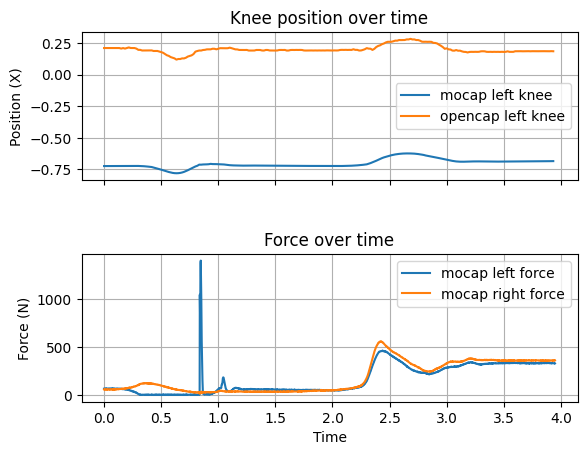

In [23]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.5)

# Top subplot with the mocap left knee and opencap left knee
axs[0].plot(mocap_markers.Time.t, mocap_markers.Knee.X, label="mocap left knee")
axs[0].plot(opencap_markers.Time.t, opencap_markers.LKnee.X, label="opencap left knee")
axs[0].set_title('Knee position over time')
axs[0].set_ylabel('Position (X)')
axs[0].legend()
axs[0].grid(True)

# Bottom subplot with the mocap left force
axs[1].plot(mocap_forces_in_opencap_frame.time, mocap_forces_in_opencap_frame.ground_force_l_vy, label="mocap left force")
axs[1].plot(mocap_forces_in_opencap_frame.time, mocap_forces_in_opencap_frame.ground_force_r_vy, label="mocap right force")
axs[1].set_title('Force over time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Force (N)')
axs[1].legend()
axs[1].grid(True)

plt.show()